# Test de la librairie DeepExplain #

Dans ce notebook, on va tester la librairie DeepExplain qui offre les algorithmes suivants compatibles avec Keras et Tensorflow :
- Saliency maps
- Gradient * Input
- Integrated Gradients
- DeepLIFT
- ε-LRP

Tous ces algorithmes permettent de comprendre quels pixels ont été décisifs et au contraire quels ont été ceux jouant en défaveur de la classification d'une image. 

Lien du git : https://github.com/marcoancona/DeepExplain

Pour visualiser le fonctionnement de ces algorithmes, je vais dans un premier temps tester leur efficacité sur Mnist afin de reproduire les résultats des exemples. Ensuite je me concentrerai plus particulièrement sur la librarie LRP que je testerai sur des images sujettes à une classification plus variée. Enfin, je testerai l'efficacité de LRP sur des réseaux de classification multi labels tels que RetinaNet. 

## Tests sur la librairie sur mnist##

Pour vérifier la bonne installation de la librairie DeepExplain, on va tester l'efficacité de tous les algorithmes sur la librairie Mnist.

### Mise en place d'un réseau simple entrainé sur Mnist ###

On va tout d'abord entraîner un réseau convolutif classique sur Mnist.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

# Import DeepExplain
from deepexplain.tensorflow import DeepExplain

Using TensorFlow backend.


In [2]:
# Build and train a network.

batch_size = 128
num_classes = 10
epochs = 3

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
x_train = (x_train - 0.5) * 2
x_test = (x_test - 0.5) * 2
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax')) 
# ^ IMPORTANT: notice that the final softmax must be in its own layer 
# if we want to target pre-softmax units

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 184s 3ms/step - loss: 0.2233 - acc: 0.9325 - val_loss: 0.0522 - val_acc: 0.9825
Epoch 2/3
60000/60000 [==============================] - 177s 3ms/step - loss: 0.0791 - acc: 0.9760 - val_loss: 0.0366 - val_acc: 0.9879
Epoch 3/3
60000/60000 [==============================] - 177s 3ms/step - loss: 0.0583 - acc: 0.9827 - val_loss: 0.0331 - val_acc: 0.9893
Test loss: 0.03309114753230242
Test accuracy: 0.9893


In [4]:
with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model.layers[-2].output)
    target_tensor = fModel(input_tensor)
    
    xs = x_test[0:10]
    ys = y_test[0:10]
    
    print("xs")
    print(xs.shape)
    print("ys")
    print(ys.shape)
    print("input tensor")
    print(input_tensor.shape)
    print("target tensor")
    print(target_tensor.shape)
    
    attributions_gradinput = de.explain('grad*input', target_tensor * ys, input_tensor, xs)
    attributions_saliency = de.explain('saliency', target_tensor * ys, input_tensor, xs)
    attributions_intgrad = de.explain('intgrad', target_tensor * ys, input_tensor, xs)
    attributions_deeplift = de.explain('deeplift', target_tensor * ys, input_tensor, xs)
    attributions_elrp = de.explain('elrp', target_tensor * ys, input_tensor, xs)
    attributions_occlusion = de.explain('occlusion', target_tensor * ys, input_tensor, xs)
    
    # voir l'odre de grandeur de la matrice des attributions afin de savoir comment tracer les résultats
    print(attributions_elrp)

xs
(10, 28, 28, 1)
ys
(10, 10)
input tensor
(?, 28, 28, 1)
target tensor
(?, 10)
DeepExplain: running "grad*input" explanation method (2)
Model with multiple inputs:  False
DeepExplain: running "saliency" explanation method (1)
Model with multiple inputs:  False
DeepExplain: running "intgrad" explanation method (3)
Model with multiple inputs:  False
DeepExplain: running "deeplift" explanation method (5)
Model with multiple inputs:  False
DeepExplain: running "elrp" explanation method (4)
Model with multiple inputs:  False
DeepExplain: running "occlusion" explanation method (6)
Model with multiple inputs:  False
Input shape: (28, 28, 1); window_shape (1, 1, 1); step 1
[[[[-1.0509545e-03]
   [-1.8045200e-03]
   [ 4.6460357e-04]
   ...
   [-9.5897110e-04]
   [-1.6473877e-04]
   [-0.0000000e+00]]

  [[-3.4362108e-03]
   [-2.1192657e-03]
   [ 4.3758936e-04]
   ...
   [-1.8162380e-03]
   [-1.6427058e-03]
   [-0.0000000e+00]]

  [[ 9.6777693e-04]
   [ 5.4804579e-04]
   [ 2.4870993e-03]
   ...

In [5]:
from skimage import feature, transform
import numpy as np
import matplotlib.pyplot as plt

def plot(data, xi=None, cmap='RdBu_r', axis=plt, percentile=100, dilation=3.0, alpha=0.8):
    dx, dy = 0.05, 0.05
    xx = np.arange(0.0, data.shape[1], dx)
    yy = np.arange(0.0, data.shape[0], dy)
    xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
    extent = xmin, xmax, ymin, ymax
    cmap_xi = plt.get_cmap('Greys_r')
    cmap_xi.set_bad(alpha=0)
    overlay = None
    if xi is not None:
        # Compute edges (to overlay to heatmaps later)
        xi_greyscale = xi if len(xi.shape) == 2 else np.mean(xi, axis=-1)
        in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
        edges = feature.canny(in_image_upscaled).astype(float)
        edges[edges < 0.5] = np.nan
        edges[:5, :] = np.nan
        edges[-5:, :] = np.nan
        edges[:, :5] = np.nan
        edges[:, -5:] = np.nan
        overlay = edges

    abs_max = np.percentile(np.abs(data), percentile)
    abs_min = abs_max

    if len(data.shape) == 3:
        data = np.mean(data, 2)
    axis.imshow(data, extent=extent, interpolation='none', cmap=cmap, vmin=-abs_min, vmax=abs_max)
    if overlay is not None:
        axis.imshow(overlay, extent=extent, interpolation='none', cmap=cmap_xi, alpha=alpha)
    axis.axis('off')
    return axis

/Users/rblin/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/Users/rblin/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


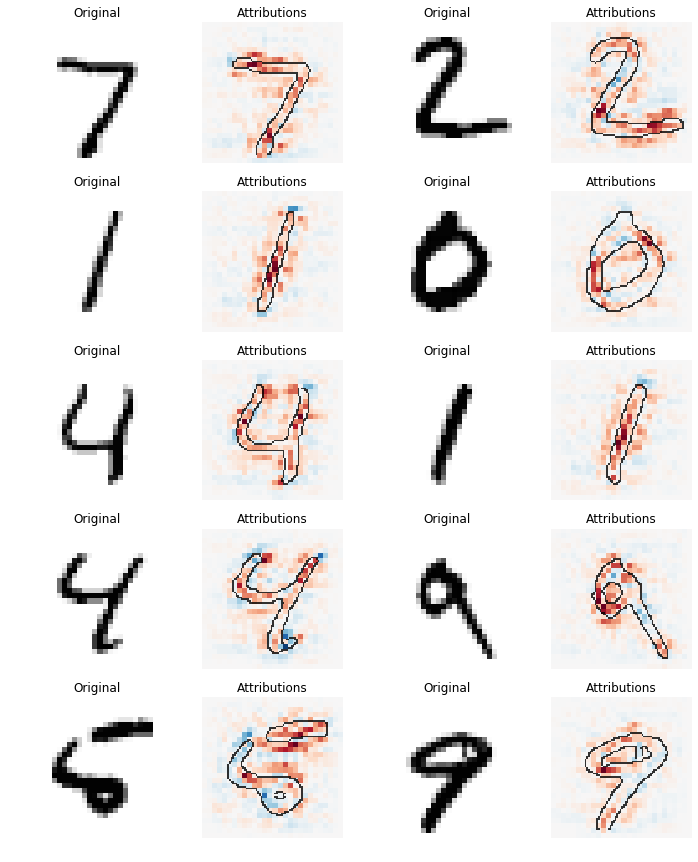

In [6]:
# Plot attributions grad*input
%matplotlib inline

n_cols = 4
n_rows = int(len(attributions_gradinput) / 2)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))

for i, a in enumerate(attributions_gradinput):
    row, col = divmod(i, 2)
    plot(xs[i].reshape(28, 28), cmap='Greys', axis=axes[row, col*2]).set_title('Original')
    plot(a.reshape(28,28), xi = xs[i], axis=axes[row,col*2+1]).set_title('Attributions')

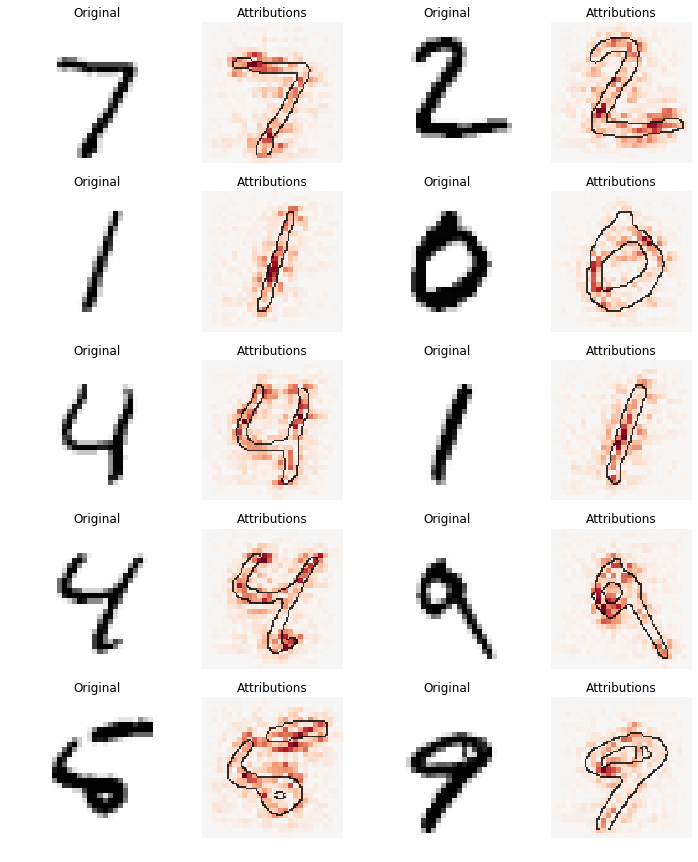

In [7]:
# Plot attributions saliency
%matplotlib inline

n_cols = 4
n_rows = int(len(attributions_saliency) / 2)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))

for i, a in enumerate(attributions_saliency):
    row, col = divmod(i, 2)
    plot(xs[i].reshape(28, 28), cmap='Greys', axis=axes[row, col*2]).set_title('Original')
    plot(a.reshape(28,28), xi = xs[i], axis=axes[row,col*2+1]).set_title('Attributions')

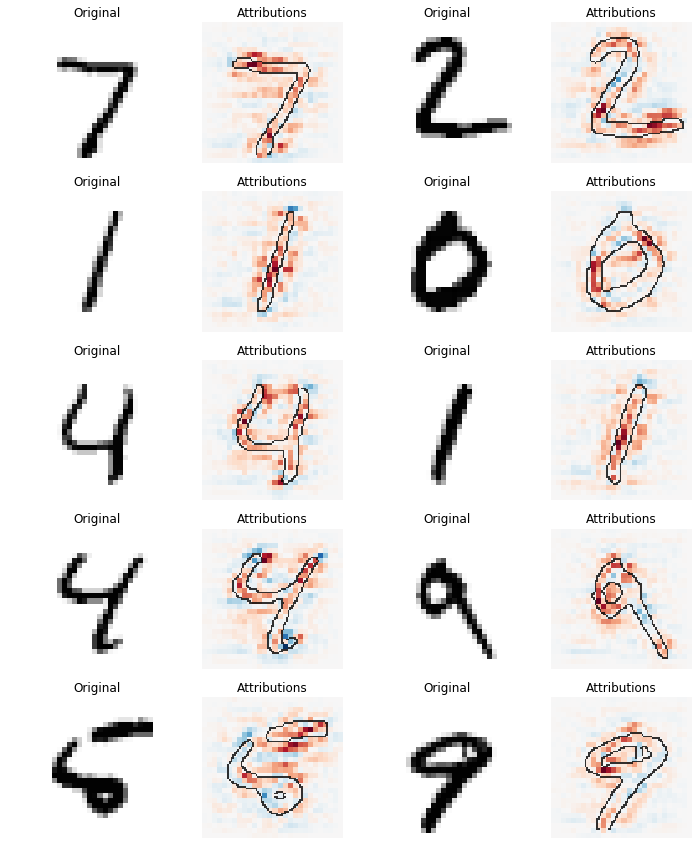

In [8]:
# Plot attributions intgrad
%matplotlib inline

n_cols = 4
n_rows = int(len(attributions_intgrad) / 2)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))

for i, a in enumerate(attributions_intgrad):
    row, col = divmod(i, 2)
    plot(xs[i].reshape(28, 28), cmap='Greys', axis=axes[row, col*2]).set_title('Original')
    plot(a.reshape(28,28), xi = xs[i], axis=axes[row,col*2+1]).set_title('Attributions')

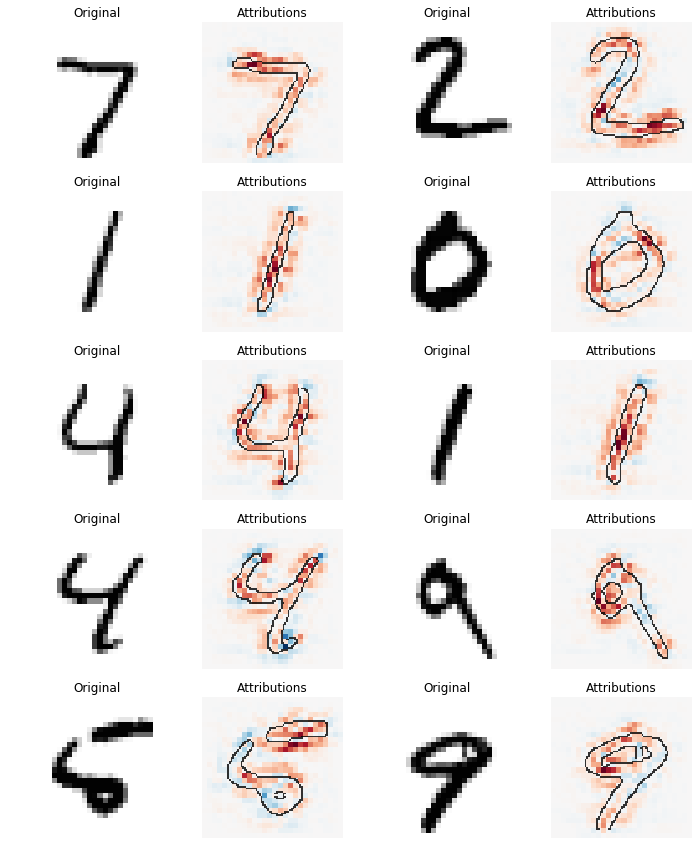

In [9]:
# Plot attributions deeplift
%matplotlib inline

n_cols = 4
n_rows = int(len(attributions_deeplift) / 2)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))

for i, a in enumerate(attributions_deeplift):
    row, col = divmod(i, 2)
    plot(xs[i].reshape(28, 28), cmap='Greys', axis=axes[row, col*2]).set_title('Original')
    plot(a.reshape(28,28), xi = xs[i], axis=axes[row,col*2+1]).set_title('Attributions')

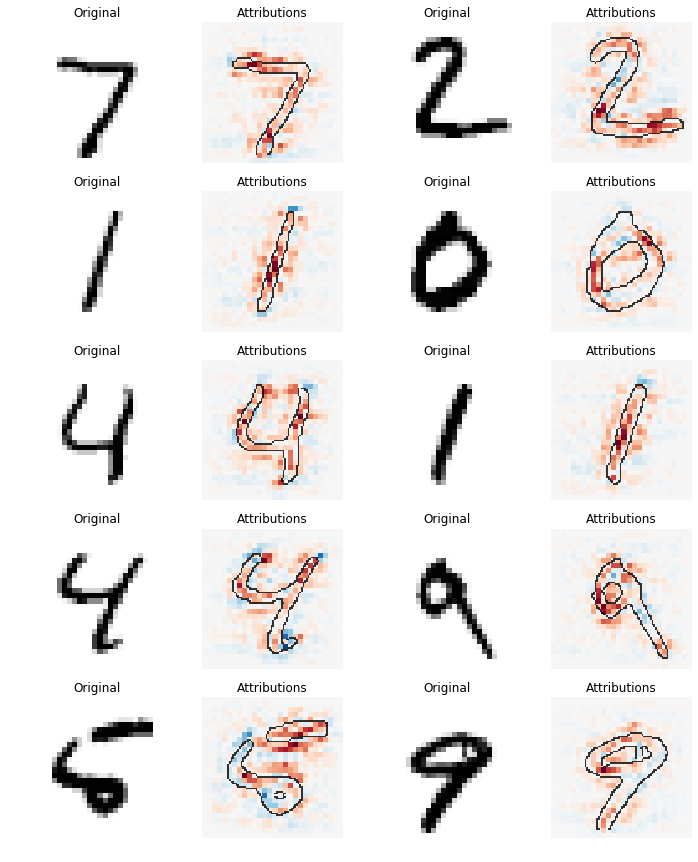

In [10]:
# Plot attributions elrp
%matplotlib inline

n_cols = 4
n_rows = int(len(attributions_elrp) / 2)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))

for i, a in enumerate(attributions_elrp):
    row, col = divmod(i, 2)
    plot(xs[i].reshape(28, 28), cmap='Greys', axis=axes[row, col*2]).set_title('Original')
    plot(a.reshape(28,28), xi = xs[i], axis=axes[row,col*2+1]).set_title('Attributions')

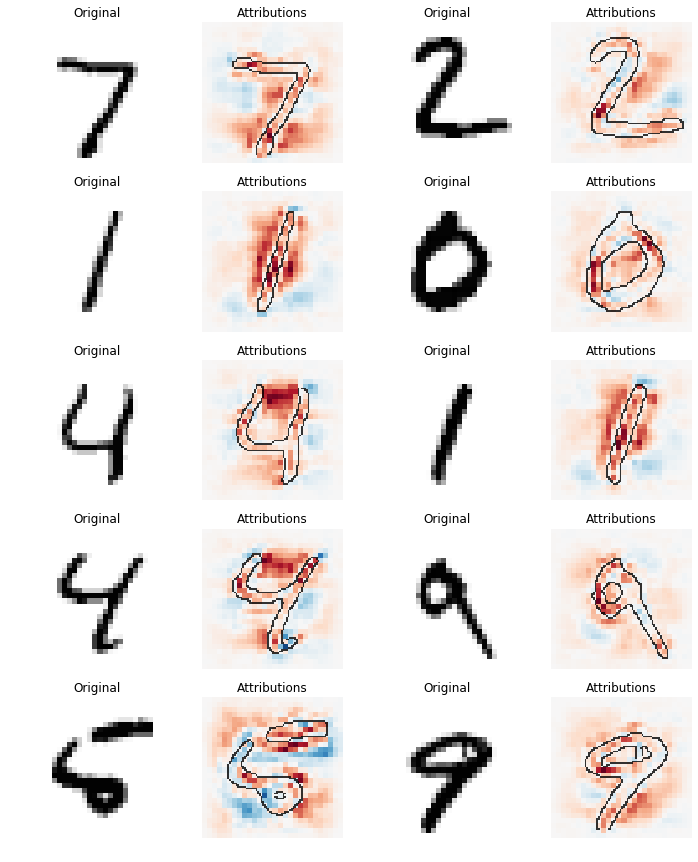

In [11]:
# Plot attributions occlusion
%matplotlib inline

n_cols = 4
n_rows = int(len(attributions_occlusion) / 2)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))

for i, a in enumerate(attributions_occlusion):
    row, col = divmod(i, 2)
    plot(xs[i].reshape(28, 28), cmap='Greys', axis=axes[row, col*2]).set_title('Original')
    plot(a.reshape(28,28), xi = xs[i], axis=axes[row,col*2+1]).set_title('Attributions')

Maintenant que j'ai réussi à reproduire les résultats des exemples, je vais me focaliser sur la méthode LRP. 

### Mise en place du réseau ResNet50 ###

Afin de tester l'efficacité de l'algorithme LRP sur des images qui s'approchent le plus du cadre de ma thèse, soient des images de scène routières, on va regarder les résultats qu'il donne sur des images classées à l'aide de ResNet50. En effet, ResNet50 étant le backbone de RetinaNet, cela nous rapproche de notre objectif final, soit de comprendre les zones de RetinaNet identifiées pour effectuer une classification. 

On retrouve les 1000 classes d'Imagenet dans l'ordre à ce lien :

https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

# Import DeepExplain
from deepexplain.tensorflow import DeepExplain

from skimage import feature, transform
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [26]:
# Test de LRP sur ResNet50 entraîné sur ImageNet

import cv2

model2 = keras.applications.resnet50.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

with DeepExplain(session=K.get_session()) as de:
    input_tensor = model2.layers[0].input
    
    # ici, pour l'argument outputs = model2.layers[-1].output, il faut faire -nbCouchesDense afin d'enlever les couches Dense sinon ne fonctionne pas
    fModel = Model(inputs=input_tensor, outputs = model2.layers[-1].output)
    target_tensor = fModel(input_tensor)
    
    #xs = x_test[0:10]
    #ys = y_test[0:10]
    
    width = 224
    height = 224
    
    im = cv2.imread("/Users/rblin/Documents/test_voiture.jpg")
    # Besoin de redimensionner l'image pour qu'elle soit de taille 224*224 pour être passée en entrée de ResNet50
    im_resize = cv2.resize(im,(width,height))
    # Le vecteur xs doit être au format [nbElements, (dimensions élément)]
    xs = np.reshape(im_resize, (1, im_resize.shape[0], im_resize.shape[1], im_resize.shape[2]))
    ys = model2.predict_on_batch(xs)
    #print(ys)
    
    print(np.argmax(ys)) # Ceci permet de savoir si l'image est bien classifiée
    
    print("xs")
    print(xs.shape)
    print("ys")
    print(ys.shape)
    print("input tensor")
    print(input_tensor.shape)
    print("target tensor")
    print(target_tensor.shape)
    #print(model2.layers), pour le débugage, afin de regarder quelles sont les couches Dense de la fin afin de les enlever
    
    """xs
    (10, 28, 28, 1)
    ys
    (10, 10)
    input tensor
    (?, 28, 28, 1)
    target tensor
    (?, 10)
    Le target tensor devrait donc être de taille (?, 1000)
    """
    
    attributions = de.explain('elrp', target_tensor * ys, input_tensor, xs)

717
xs
(1, 224, 224, 3)
ys
(1, 1000)
input tensor
(?, 224, 224, 3)
target tensor
(?, 1000)
DeepExplain: running "elrp" explanation method (4)
Model with multiple inputs:  False


<Figure size 432x288 with 0 Axes>

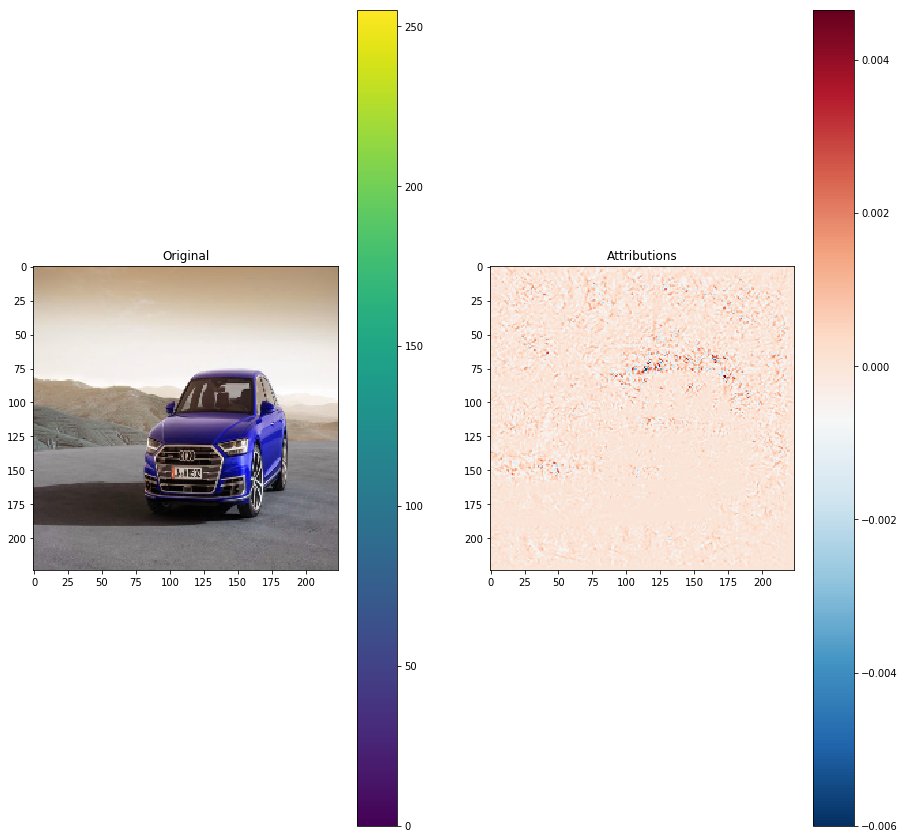

In [17]:
%matplotlib inline

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

plt.figure(1)
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(im_resize)
plt.title('Original')
plt.colorbar()
plt.subplot(1,2,2)
# Convertir l'image en niveaux de gris pour pouvoir visualiser les pixels importants pour la décision
plt.imshow(rgb2gray(attributions[0]), cmap='RdBu_r')
plt.title('Attributions')
plt.colorbar()

Essayons maintenant avec une autre image de voiture dans le brouillard et dans la neige bien classifées pour comparer les résultats.

In [32]:
# Test de LRP sur ResNet50 entraîné sur ImageNet

import cv2

model2 = keras.applications.resnet50.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

with DeepExplain(session=K.get_session()) as de:
    input_tensor = model2.layers[0].input
    
    # ici, pour l'argument outputs = model2.layers[-1].output, il faut faire -nbCouchesDense afin d'enlever les couches Dense sinon ne fonctionne pas
    fModel = Model(inputs=input_tensor, outputs = model2.layers[-1].output)
    target_tensor = fModel(input_tensor)
    
    #xs = x_test[0:10]
    #ys = y_test[0:10]
    
    width = 224
    height = 224
    
    im = cv2.imread("/Users/rblin/Documents/Brouillard/7.jpg")
    # Besoin de redimensionner l'image pour qu'elle soit de taille 224*224 pour être passée en entrée de ResNet50
    im_resize = cv2.resize(im,(width,height))
    # Le vecteur xs doit être au format [nbElements, (dimensions élément)]
    xs = np.reshape(im_resize, (1, im_resize.shape[0], im_resize.shape[1], im_resize.shape[2]))
    #ys = model2.predict_on_batch(xs)
    #print(ys.shape)
    ys = np.zeros((1,1000))
    ys[0, 717] = 1 # Ici la classe qu'on veut évaluer est la voiture, afin de voir quels sont les pixels en faveur de cette classification
    print(np.argmax(ys))
    
    attributions = de.explain('elrp', target_tensor * ys, input_tensor, xs)

717
DeepExplain: running "elrp" explanation method (4)
Model with multiple inputs:  False


<Figure size 432x288 with 0 Axes>

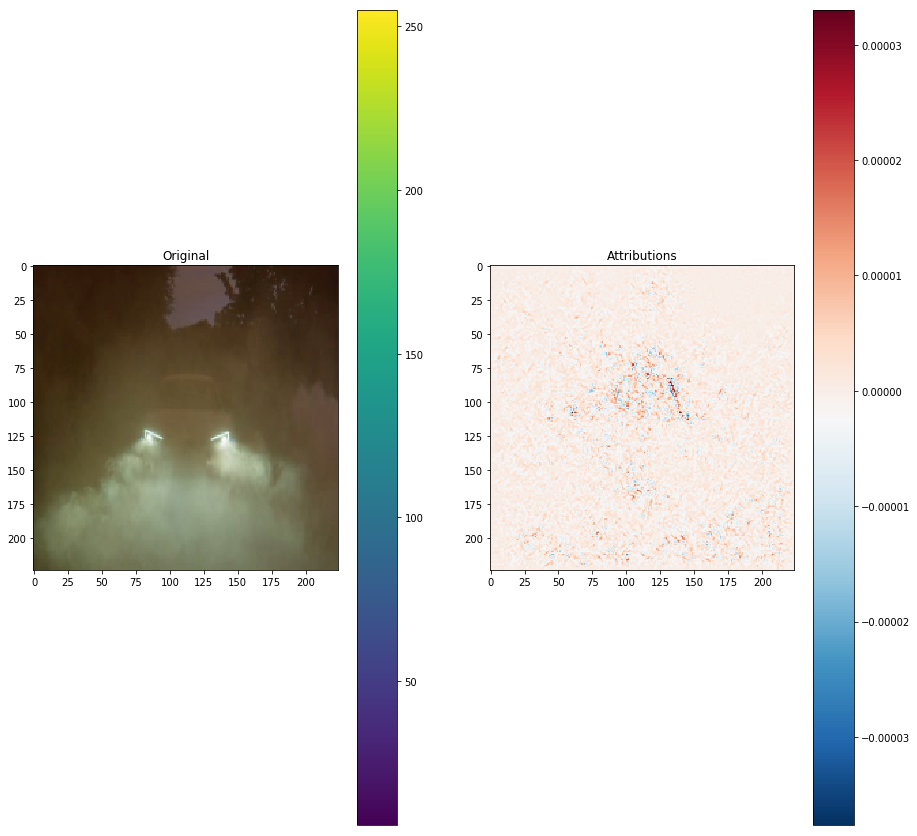

In [33]:
%matplotlib inline

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

plt.figure(1)
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(im_resize)
plt.title('Original')
plt.colorbar()
plt.subplot(1,2,2)
# Convertir l'image en niveaux de gris pour pouvoir visualiser les pixels importants pour la décision
plt.imshow(rgb2gray(attributions[0]), cmap='RdBu_r')
plt.title('Attributions')
plt.colorbar()

In [36]:
# Test de LRP sur ResNet50 entraîné sur ImageNet

import cv2

model2 = keras.applications.resnet50.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

with DeepExplain(session=K.get_session()) as de:
    input_tensor = model2.layers[0].input
    
    # ici, pour l'argument outputs = model2.layers[-1].output, il faut faire -nbCouchesDense afin d'enlever les couches Dense sinon ne fonctionne pas
    fModel = Model(inputs=input_tensor, outputs = model2.layers[-1].output)
    target_tensor = fModel(input_tensor)
    
    width = 224
    height = 224
    
    im = cv2.imread("/Users/rblin/Documents/voiture_neige.jpg")
    # Besoin de redimensionner l'image pour qu'elle soit de taille 224*224 pour être passée en entrée de ResNet50
    im_resize = cv2.resize(im,(width,height))
    # Le vecteur xs doit être au format [nbElements, (dimensions élément)]
    xs = np.reshape(im_resize, (1, im_resize.shape[0], im_resize.shape[1], im_resize.shape[2]))
    # ys = model2.predict_on_batch(xs)
    ys = np.zeros((1,1000))
    ys[0, 717] = 1
    print(np.argmax(ys))
    
    attributions = de.explain('elrp', target_tensor * ys, input_tensor, xs)

717
DeepExplain: running "elrp" explanation method (4)
Model with multiple inputs:  False


<Figure size 432x288 with 0 Axes>

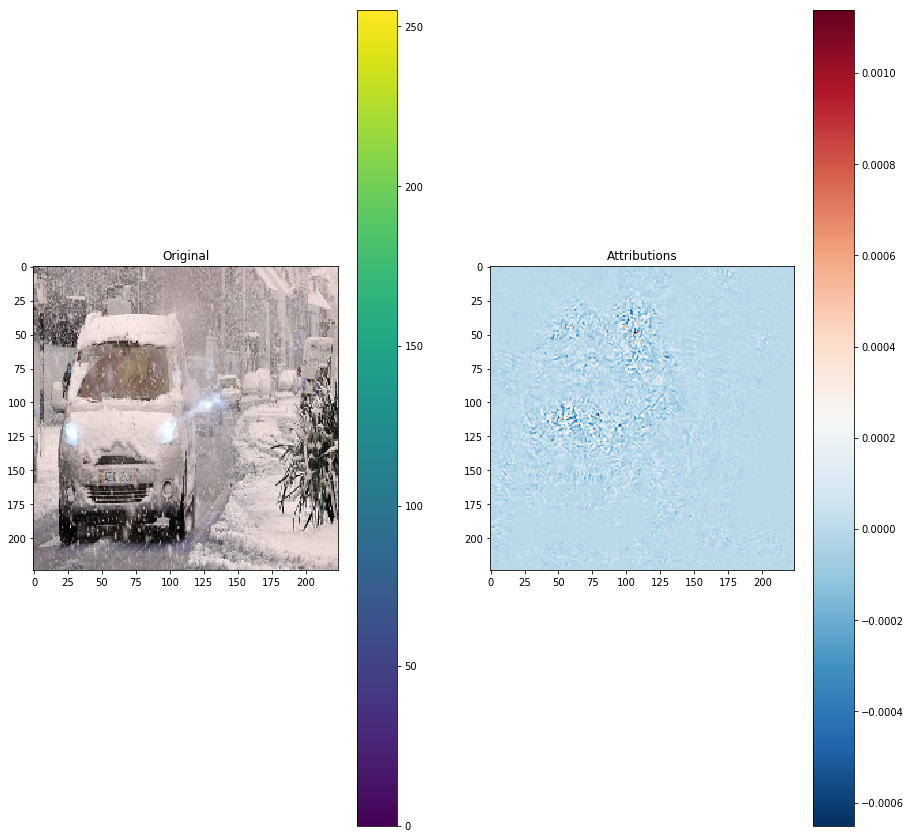

In [37]:
%matplotlib inline

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

plt.figure(1)
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(im_resize)
plt.title('Original')
plt.colorbar()
plt.subplot(1,2,2)
# Convertir l'image en niveaux de gris pour pouvoir visualiser les pixels importants pour la décision
plt.imshow(rgb2gray(attributions[0]), cmap='RdBu_r')
plt.title('Attributions')
plt.colorbar()

Après avoir effectué quelques expériences avec Resnet50 entraîné sur Imagenet, je me suis rendue compte que le fait que les classes neige et brouillard existent faussent les résultats de reconnaissance des voitures. Pour pallier à ce problème, je vais effectué d'autres tests avec le même réseau entraîné sur CIFAR 10 qui contient 10 classes d'objets dont parmi elles les voitures et aucune classe caractérisant des conditions météorologiques dégradées.

Lien vers les classes de CIFAR-10 :

https://www.cs.toronto.edu/~kriz/cifar.html

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))

import keras
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.optimizers import Adam

# Import DeepExplain
from deepexplain.tensorflow import DeepExplain

from skimage import feature, transform
import numpy as np
import matplotlib.pyplot as plt

import cv2

Using TensorFlow backend.


In [2]:
NUM_CLASSES = 10
BATCH_SIZE = 2
NUM_EPOCHS = 3
use_data_aug = True

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Chargement de peu de données afin de pouvoir faire fonctionner le réseau
x_train = x_train.reshape(x_train.shape[0], 32, 32, 3)
y_train = y_train
x_test = x_test.reshape(x_test.shape[0], 32, 32, 3)
y_test = y_test

#print(x_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

# Normalize the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [ ]:
# Test de LRP sur ResNet50 entraîné sur CIFAR-10

model3 = keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet')

# add a global spatial average pooling layer
x = model3.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)
# and a logistic layer -- 10 classes for CIFAR10
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# this is the model we will train
model4 = Model(inputs=model3.input, outputs=predictions)


opt = keras.optimizers.rmsprop(lr=0.1, decay=0.5)

model4.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

model4.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(x_test, y_test), shuffle=False)

model4.save('resnet50_cifar10.h5')

# Pour entraîner le réseau avec Cifar10 avec plus d'epochs, exécuter le programme Train_ResNet50_cifar10.py, sinon récupérer les poids du fichier resnet50_cifar10.h5

/Users/rblin/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Train on 50000 samples, validate on 10000 samples
Epoch 1/3
  574/50000 [..............................] - ETA: 3:54:01 - loss: 0.3238 - acc: 0.9000

In [4]:
with DeepExplain(session=K.get_session()) as de:
    input_tensor = model4.layers[0].input
    
    # ici, pour l'argument outputs = model2.layers[-1].output, il faut faire -nbCouchesDense afin d'enlever les couches Dense sinon ne fonctionne pas
    fModel = Model(inputs=input_tensor, outputs = model4.layers[-1].output)
    target_tensor = fModel(input_tensor)
    
    #xs = x_test[0:10]
    #ys = y_test[0:10]
    
    width = 224
    height = 224
    
    im = cv2.imread("/Users/rblin/Documents/test_voiture.jpg")
    # Besoin de redimensionner l'image pour qu'elle soit de taille 224*224 pour être passée en entrée de ResNet50
    im_resize = cv2.resize(im,(width,height))
    # Le vecteur xs doit être au format [nbElements, (dimensions élément)]
    xs = np.reshape(im_resize, (1, im_resize.shape[0], im_resize.shape[1], im_resize.shape[2]))
    ys = model4.predict_on_batch(xs)
    print(np.argmax(ys))
    
    attributions = de.explain('elrp', target_tensor * ys, input_tensor, xs)

6
DeepExplain: running "elrp" explanation method (4)
Model with multiple inputs:  False


<Figure size 432x288 with 0 Axes>

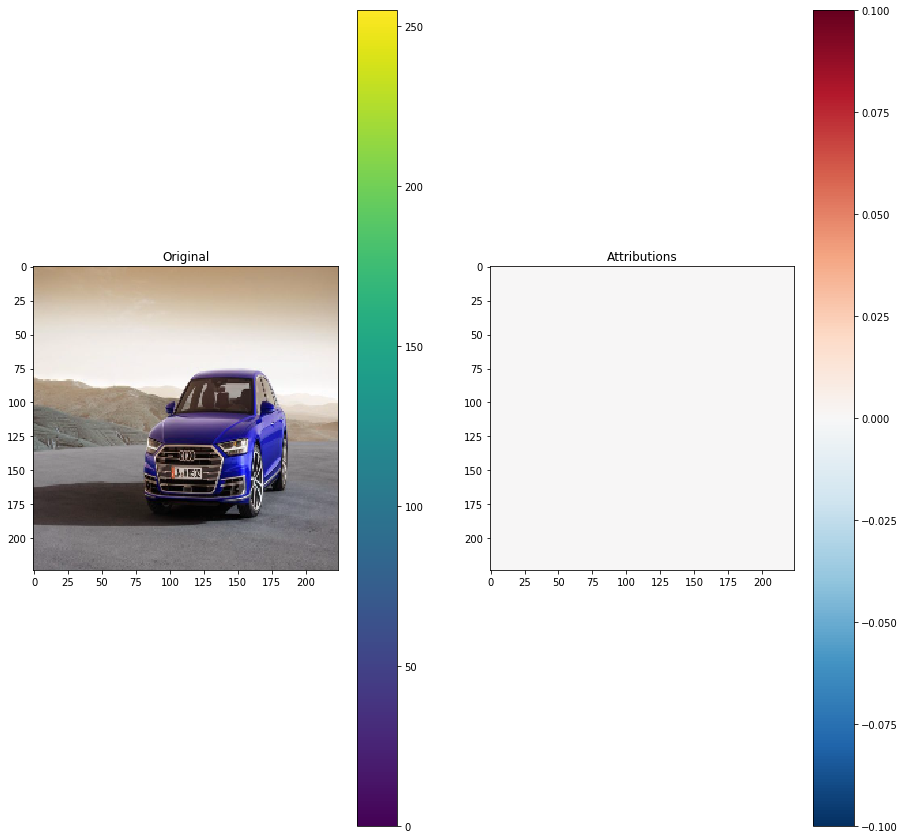

In [5]:
%matplotlib inline

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

plt.figure(1)
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(im_resize)
plt.title('Original')
plt.colorbar()
plt.subplot(1,2,2)
# Convertir l'image en niveaux de gris pour pouvoir visualiser les pixels importants pour la décision
plt.imshow(rgb2gray(attributions[0]), cmap='RdBu_r')
plt.title('Attributions')
plt.colorbar()